In [1]:
import pandas as pd

# 한글 폰트 깨짐 방지
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#에러 무시
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale, minmax_scale, robust_scale

import xgboost as xgb

import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'


In [2]:
hts = pd.read_csv('hts.csv', encoding = 'CP949')

In [3]:
hts

,연도,경기코드,타구코드,선수코드,타자 팀 코드,이닝,타구속도,발사각도,타격결과,투구구속,해당구장
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척
4,2018,20180324HHWO0,180324_142050,68730,HH,2,54.11,16.4,번트안타,134.07,고척
...,...,...,...,...,...,...,...,...,...,...,...
120740,2021,20210711LTSS0,210711_195321,50458,SS,8,141.23,-4.9,땅볼아웃,137.76,대구
120741,2021,20210711LTSS0,210711_195424,62415,SS,8,101.09,31.8,1루타,138.51,대구
120742,2021,20210711LTSS0,210711_195627,75566,SS,8,146.84,33.4,홈런,134.10,대구
120743,2021,20210711LTSS0,210711_200047,69418,SS,8,146.12,23.9,홈런,139.96,대구


In [4]:
# 번트는 팀 직전 타구이기 때문에 삭제

hts = hts.loc[(hts['타격결과'] != '번트안타')&
       (hts['타격결과'] != '번트아웃')&
       (hts['타격결과'] != '희생번트')]
hts.reset_index(drop = True, inplace = True)

In [5]:
# 안타 여부 표시
hts['안타여부'] = 0
hts['장타여부'] = 0

# 안타가 된 타구만 1로 
hts['안타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '2루타')] = 1
hts['안타여부'][(hts['타격결과'] == '3루타')] = 1
hts['안타여부'][(hts['타격결과'] == '홈런')] = 1
hts['안타여부'][(hts['타격결과'] == '직선타')] = 1

# 장타가 된 타구
hts['장타여부'][(hts['타격결과'] == '1루타')] = 1
# hts['안타여부'][(hts['타격결과'] == '내야안타(1루타)')] = 1
hts['장타여부'][(hts['타격결과'] == '2루타')] = 2
hts['장타여부'][(hts['타격결과'] == '3루타')] = 3
hts['장타여부'][(hts['타격결과'] == '홈런')] = 4

In [6]:
# 안타가 된 타구만 추출
hts_hit = hts.loc[(hts['안타여부'] == 1)]

# 안타가 되지 않은 타구 추출
hts_nonhit = hts.loc[(hts['안타여부'] == 0)]

In [7]:
hts_hit = hts_hit[['타구속도', '발사각도', '타격결과']]
hts_nonhit = hts_nonhit[['타구속도', '발사각도', '타격결과']]

In [8]:
hts_hit.reset_index(drop = True, inplace = True)
hts_nonhit.reset_index(drop = True, inplace = True)

In [9]:
print(len(hts_hit))
print(len(hts_nonhit))

46387
74027


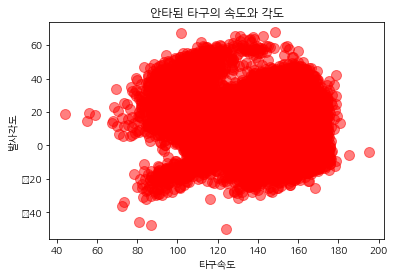

In [10]:
# 안타 타구

plt.plot('타구속도', 
         '발사각도', 
         data=hts_hit, 
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='red', 
         alpha=0.5)
# plt.subplot(1, 2, 1)
plt.title('안타된 타구의 속도와 각도')
plt.xlabel('타구속도')
plt.ylabel('발사각도')
plt.show()

# plt.plot('타구속도', 
#          '발사각도', 
#          data=hts_nonhit, 
#          linestyle='none', 
#          marker='o', 
#          markersize=10,
#          color='blue', 
#          alpha=0.5)
# plt.subplot(1, 2, 2)   
# plt.title('안타가 안 된 타구의 속도와 각도')
# plt.xlabel('타구속도')
# plt.ylabel('발사각도')
# plt.show()
#              # nrows=2, ncols=1, index=2

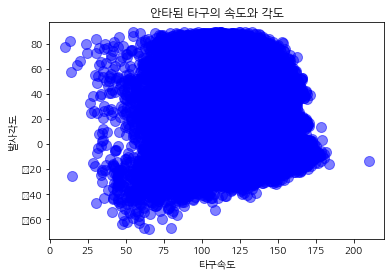

In [11]:
# 안타 안된 타구

plt.plot('타구속도', 
         '발사각도', 
         data=hts_nonhit, 
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='blue', 
         alpha=0.5)

plt.title('안타된 타구의 속도와 각도')
plt.xlabel('타구속도')
plt.ylabel('발사각도')
plt.show()

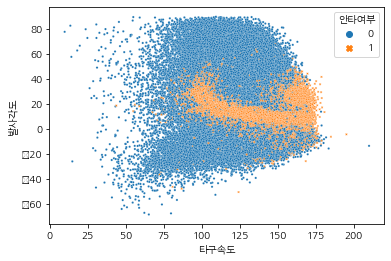

In [12]:
fig = sns.scatterplot(x = '타구속도', 
                y = '발사각도', 
                hue = '안타여부', # different colors by group
                style = '안타여부', # different shapes by group
                s = 5, # marker size
                data = hts)

# fig.fig.set_size_inches(5, 5) 
plt.show()

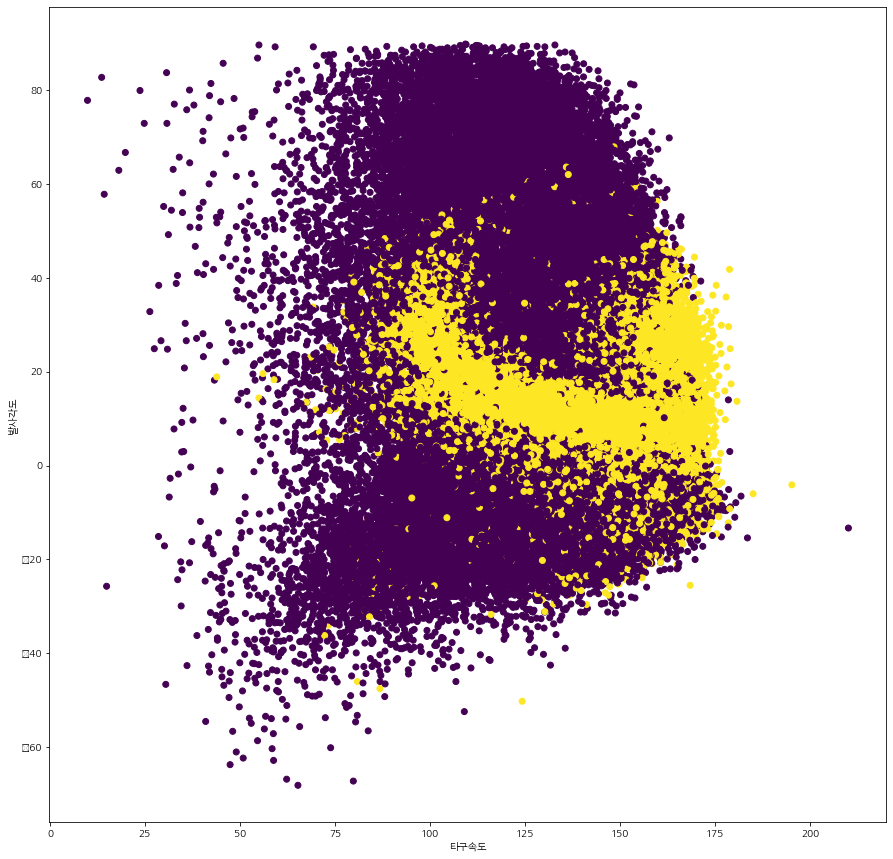

In [13]:
# 타구 속도가 75이상넘어가면서 안타가 생성되는 것을 볼 수 있음
# 75 이하는 번트로 예상

plt.figure(figsize=(15,15))
plt.scatter(hts['타구속도'], hts['발사각도'], c = hts['안타여부'], marker = 'o')
plt.xlabel('타구속도')
plt.ylabel('발사각도')
plt.show()

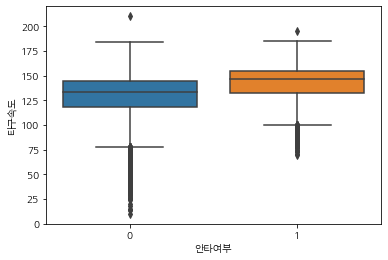

In [14]:
rot = sns.boxplot(x='안타여부',y = '타구속도', data = hts)

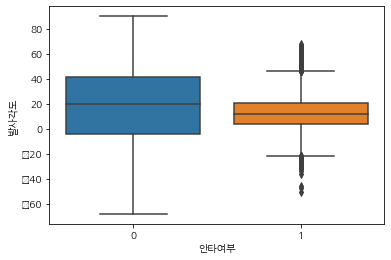

In [15]:
rot = sns.boxplot(x='안타여부',y = '발사각도', data = hts)

In [16]:
# 발사각도 IQR

Q1 = hts_hit['발사각도'].quantile(.25)
Q3 = hts_hit['발사각도'].quantile(.75)
IQR = Q3 - Q1
Q2 = hts_hit['발사각도'].quantile(.5)
Q4 = hts_hit['발사각도'].quantile(1)

In [17]:
hts_hit.describe()

,타구속도,발사각도
count,42785.000000,42785.000000
mean,142.081064,12.204394
std,17.528911,12.794133
min,69.200000,-50.200000
25%,132.700000,3.600000
50%,146.500000,11.800000
75%,154.810000,20.600000
max,195.250000,67.900000


In [18]:
hts_nonhit.describe()

,타구속도,발사각도
count,77629.000000,77629.000000
mean,129.531481,20.379673
std,21.080486,27.981922
min,9.880000,-68.100000
25%,117.820000,-4.300000
50%,133.090000,20.100000
75%,144.840000,41.300000
max,210.130000,89.800000


In [19]:
# 안타 중에서 세부로 나누기

hts_hit_1 = hts_hit.loc[(hts_hit['타격결과'] == '1루타')]
hts_hit_2 = hts_hit.loc[(hts_hit['타격결과'] == '2루타')]
hts_hit_3 = hts_hit.loc[(hts_hit['타격결과'] == '3루타')]
hts_hit_hr = hts_hit.loc[(hts_hit['타격결과'] == '홈런')]

hts_hit_1.reset_index(drop = True, inplace = True)
hts_hit_2.reset_index(drop = True, inplace = True)
hts_hit_3.reset_index(drop = True, inplace = True)
hts_hit_hr.reset_index(drop = True, inplace = True)

print('1루타 개수 :', len(hts_hit_1))
print('2루타 개수 :', len(hts_hit_2))
print('3루타 개수 :', len(hts_hit_3))
print('홈런 개수 :', len(hts_hit_hr))

1루타 개수 : 29235
2루타 개수 : 8146
3루타 개수 : 672
홈런 개수 : 4732


In [20]:
print(hts_hit_1.describe())
print(hts_hit_2.describe())
print(hts_hit_3.describe())
print(hts_hit_hr.describe())

               타구속도          발사각도
count  29235.000000  29235.000000
mean     138.463661      8.119682
std       18.343727     11.573027
min       69.200000    -34.000000
25%      126.490000      0.500000
50%      142.390000      8.500000
75%      152.600000     14.200000
max      195.250000     67.900000
              타구속도        발사각도
count  8146.000000  8146.00000
mean    146.996789    16.65518
std      13.834776    10.43913
min      72.300000   -50.20000
25%     141.330000    11.20000
50%     149.740000    17.10000
75%     155.957500    22.30000
max     180.810000    65.40000
             타구속도        발사각도
count  672.000000  672.000000
mean   146.953244   19.226339
std     10.468100   10.061552
min     95.350000  -19.500000
25%    142.377500   13.675000
50%    148.140000   19.500000
75%    153.945000   25.925000
max    170.670000   56.800000
              타구속도         발사각도
count  4732.000000  4732.000000
mean    155.275731    28.781255
std       7.373702     5.625442
min     131.13000

<AxesSubplot:xlabel='타격결과', ylabel='타구속도'>

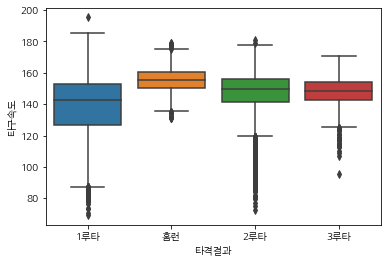

In [21]:
sns.boxplot(x='타격결과',y = '타구속도', data = hts_hit)

<AxesSubplot:xlabel='타격결과', ylabel='발사각도'>

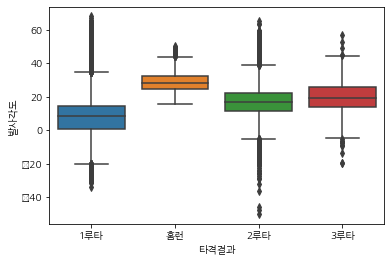

In [22]:
sns.boxplot(x='타격결과',y = '발사각도', data = hts_hit)

<AxesSubplot:xlabel='타격결과', ylabel='타구속도'>

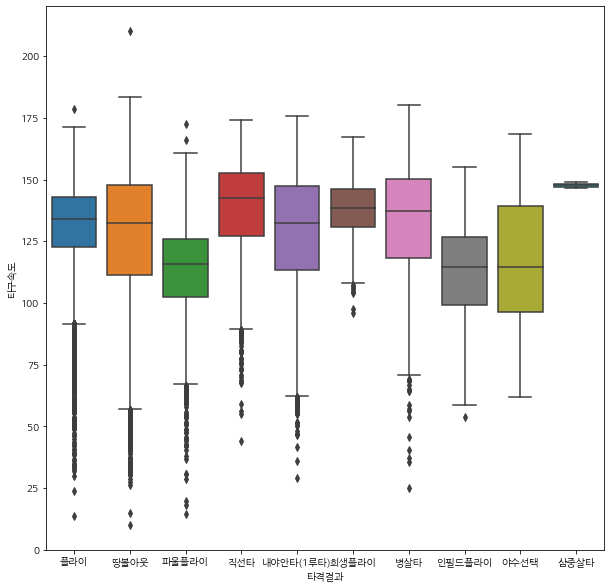

In [30]:
plt.subplots(figsize=(10, 10))
sns.boxplot(x='타격결과',y = '타구속도', data = hts_nonhit)

<AxesSubplot:xlabel='타구속도', ylabel='발사각도'>

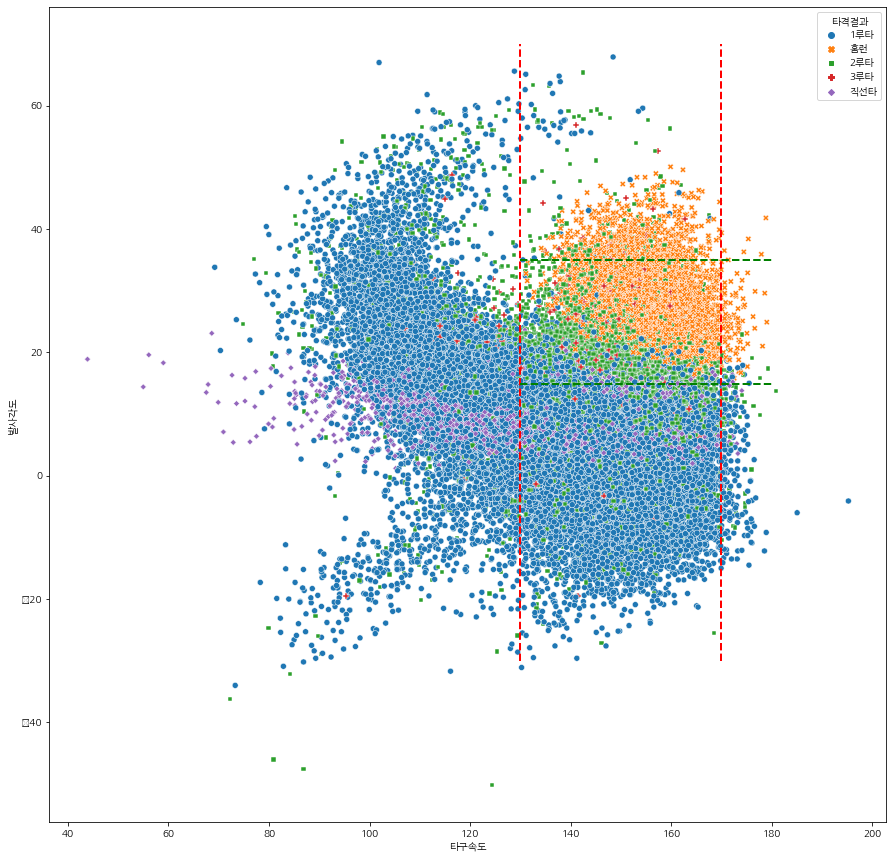

In [20]:
# 대각선으로 그려보기

plt.subplots(figsize=(15, 15))
plt.plot([130.0, 130.0], [-30, 70], "--r", linewidth=2)
plt.plot([170.0, 170.0], [-30, 70], "--r", linewidth=2)
plt.plot([130.0, 180.0], [35.0, 35.0], "--g", linewidth=2)
plt.plot([130.0, 180.0], [14.9, 14.9], "--g", linewidth=2)
sns.scatterplot(x="타구속도", y="발사각도", hue = '타격결과', style = '타격결과', data=hts_hit)

<AxesSubplot:xlabel='타구속도', ylabel='발사각도'>

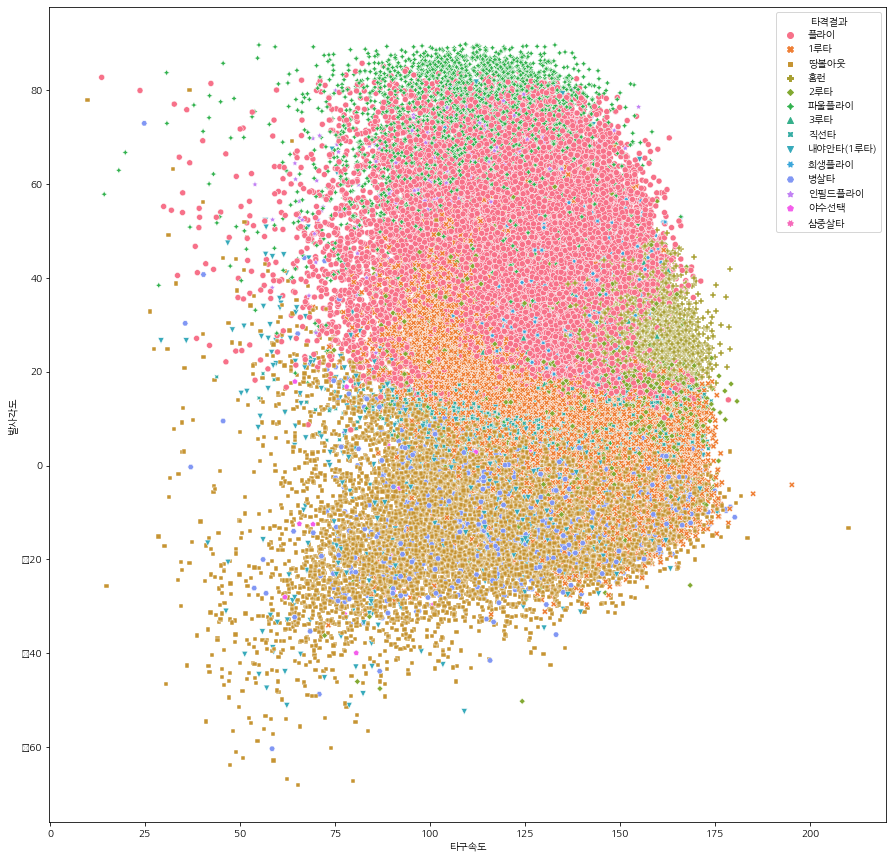

In [21]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(x="타구속도", y="발사각도", hue = '타격결과', style = '타격결과', data=hts)

# 직선타

In [25]:
# 타구속도와 각도를 아우르는 것 필요할 수도

- 배럴타구 정의하고 파생변수 만들면
 - 장타율과 배럴 파생변수가 선형?
 
- 출루율은 어떻게?

#### 표준화?
 - 발사각도, 타구속도로 파생변수 만들어서 일정 수준 이상 : 배럴 타구 정의하면 좋을듯?

## 비거리
- MLB 비거리는 풍속, 고도, 기온이 감안

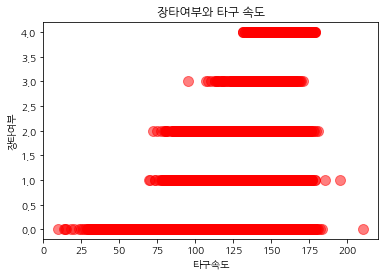

In [26]:
# Basic Scatter Plot

plt.plot('타구속도', 
         '장타여부', 
         data=hts, 
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='red', 
         alpha=0.5)

plt.title('장타여부와 타구 속도')
plt.xlabel('타구속도')
plt.ylabel('장타여부')
plt.show()

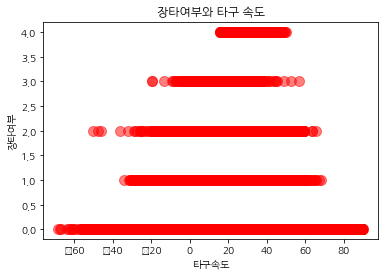

In [27]:
# Basic Scatter Plot

plt.plot('발사각도', 
         '장타여부', 
         data=hts, 
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='red', 
         alpha=0.5)

plt.title('장타여부와 타구 속도')
plt.xlabel('타구속도')
plt.ylabel('장타여부')
plt.show()

## 다음주

- 아우르는 변수 만들어서 역으로 배럴타구 정의
- 